In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F

# Dataset loading
class MNISTDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.transform = transform
        self.images = np.copy(self.read_idx_file(image_file))  
        self.labels = np.copy(self.read_labels(label_file))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def read_idx_file(self, file_path):
        with open(file_path, 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            if magic_number != 2051:
                raise ValueError(f"Invalid magic number in image file: {magic_number}")
            num_items = int.from_bytes(f.read(4), 'big')
            num_rows = int.from_bytes(f.read(4), 'big')
            num_cols = int.from_bytes(f.read(4), 'big')
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_items, num_rows, num_cols)
        return data

    def read_labels(self, file_path):
        with open(file_path, 'rb') as f:
            magic_number = int.from_bytes(f.read(4), 'big')
            if magic_number != 2049:
                raise ValueError(f"Invalid magic number in label file: {magic_number}")
            num_items = int.from_bytes(f.read(4), 'big')
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

# Setting up data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 标准化
])

# Data Path
train_image_file = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_label_file = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_image_file = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_label_file = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

train_dataset = MNISTDataset(train_image_file, train_label_file, transform=transform)
test_dataset = MNISTDataset(test_image_file, test_label_file, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
# Defining the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# training
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()  # 使用GPU训练

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Initializing the CNN model
cnn_model = CNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# training
train_model(cnn_model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.11123369157146504
Epoch 2, Loss: 0.03483882756754339
Epoch 3, Loss: 0.024739875980056333
Epoch 4, Loss: 0.017253813852093368
Epoch 5, Loss: 0.015645376202614615


Epoch 1/50, Loss: 0.26619171457134805
Epoch 1/50, Test Accuracy: 98.46%
Epoch 2/50, Loss: 0.08308243109156559
Epoch 2/50, Test Accuracy: 98.93%
Epoch 3/50, Loss: 0.06086699605904155
Epoch 3/50, Test Accuracy: 99.28%
Epoch 4/50, Loss: 0.04632332622363264
Epoch 4/50, Test Accuracy: 99.36%
Epoch 5/50, Loss: 0.04066143506916482
Epoch 5/50, Test Accuracy: 99.19%
Epoch 6/50, Loss: 0.03765420086759815
Epoch 6/50, Test Accuracy: 99.32%
Epoch 7/50, Loss: 0.03144903792299704
Epoch 7/50, Test Accuracy: 99.44%
Epoch 8/50, Loss: 0.028531951339024624
Epoch 8/50, Test Accuracy: 99.19%
Epoch 9/50, Loss: 0.026206657361709542
Epoch 9/50, Test Accuracy: 99.39%
Epoch 10/50, Loss: 0.023879854884751264
Epoch 10/50, Test Accuracy: 99.35%
Epoch 11/50, Loss: 0.02089473798478061
Epoch 11/50, Test Accuracy: 99.41%
Epoch 12/50, Loss: 0.020982048839048802
Epoch 12/50, Test Accuracy: 99.28%
Epoch 13/50, Loss: 0.020448281735778666
Epoch 13/50, Test Accuracy: 99.35%
Epoch 14/50, Loss: 0.019669189913280042
Epoch 14/50

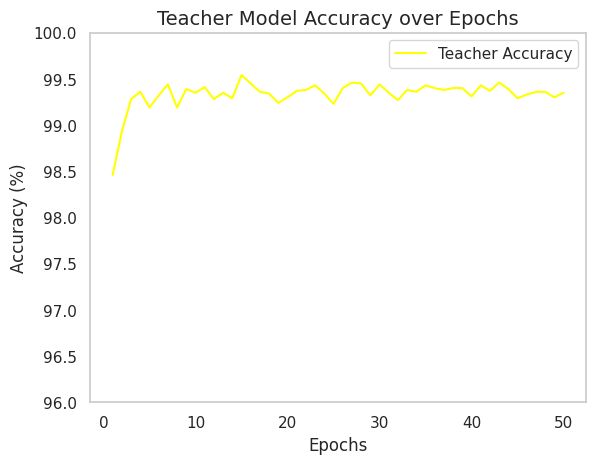

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Defining the Teacher Model
class TeacherCNN(nn.Module):
    def __init__(self):
        super(TeacherCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  
        # Convolutional Layer 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) 
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 7 * 7, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)  
        self.dropout = nn.Dropout(0.5)  # Dropout 

    def forward(self, x, temperature=1.0):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
    
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
   
        x = x.view(x.size(0), -1)
   
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
 
        x = self.fc3(x)
        return x


def train_and_evaluate_teacher(model, train_loader, test_loader, criterion, optimizer, epochs=50):
    accuracies = [] 

    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad() 
            outputs = model(images)  
            loss = criterion(outputs, labels)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()

       
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

  
        accuracy = evaluate_accuracy(model, test_loader)
        print(f'Epoch {epoch+1}/{epochs}, Test Accuracy: {accuracy:.2f}%')
        
        accuracies.append(accuracy)

    # illustration
    plt.plot(range(1, epochs+1), accuracies, label='Teacher Accuracy', color='yellow')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Teacher Model Accuracy over Epochs', fontsize=14)
    plt.ylim(96, 100)  # 设置 y 轴范围为 96 到 100
    plt.grid(False)  # 去掉网格线
    plt.legend()
    plt.show()

# initialize
teacher_model = TeacherCNN().cuda()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  

train_and_evaluate_teacher(teacher_model, train_loader, test_loader, criterion, optimizer_teacher)



In [ ]:
import torch
import torch.nn.functional as F

# PGD attack
def pgd_attack(model, images, labels, epsilon=0.5, alpha=0.02, iterations=50):
    images = images.clone().detach().cuda() 
    labels = labels.cuda()

    images.requires_grad = True 

    perturbation = torch.zeros_like(images).cuda() 

    for _ in range(iterations):
        outputs = model(images + perturbation)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad() 
        if images.grad is not None:
            images.grad.zero_() 
        loss.backward() 


        perturbation = perturbation + alpha * images.grad.sign()
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)

    perturbed_images = torch.clamp(images + perturbation, 0, 1)
    return perturbed_images.detach()  
    
#evaluate
def evaluate_attack_success(model, data_loader, epsilon=0.5, alpha=0.02, iterations=50):
    model.train()  
    attack_success = 0
    total = 0

    for images, labels in data_loader:
        images, labels = images.cuda(), labels.cuda()

        perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iterations)

        outputs = model(perturbed_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        attack_success += (predicted != labels).sum().item()

    model.eval() 
    return attack_success / total


def train_and_attack(model, train_loader, test_loader, criterion, optimizer, epochs=50, epsilon=0.5, alpha=0.02, iterations=50):
    for param in model.parameters():  
        param.requires_grad = True

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

    attack_success_rate = evaluate_attack_success(model, test_loader, epsilon, alpha, iterations)
    print(f'Training Complete. Final Attack Success Rate: {attack_success_rate * 100:.2f}%')

train_and_attack(teacher_model, train_loader, test_loader, criterion, optimizer_teacher, epochs=50, epsilon=0.5, alpha=0.02, iterations=100)



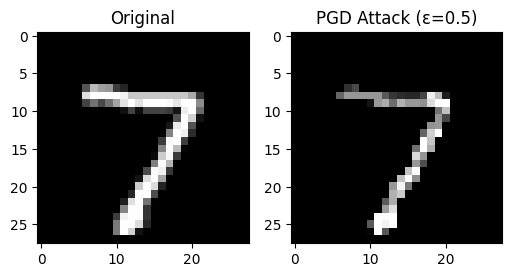

In [10]:
import matplotlib.pyplot as plt

#testing
def visualize_attack(model, images, labels, epsilon=0.5, alpha=0.01, iterations=40):
    model.eval()
    images, labels = images.cuda(), labels.cuda()
    
    perturbed_images = pgd_attack(model, images, labels, epsilon, alpha, iterations)
    
    # 转换为 numpy 进行可视化
    images = images.cpu().detach().numpy().squeeze()
    perturbed_images = perturbed_images.cpu().detach().numpy().squeeze()

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(images, cmap="gray")
    axes[0].set_title("Original")
    
    axes[1].imshow(perturbed_images, cmap="gray")
    axes[1].set_title(f"PGD Attack (ε={epsilon})")
    
    plt.show()

# 取一张测试集图片
images, labels = next(iter(test_loader))
visualize_attack(teacher_model, images[0].unsqueeze(0), labels[0].unsqueeze(0), epsilon=0.5)



In [4]:
#Distillation Model

class StudentCNN(nn.Module):
    def __init__(self):
        super(StudentCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) 

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) 

        self.fc1 = nn.Linear(64 * 7 * 7, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(0.2) 

    def forward(self, x, temperature=5):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        x = self.fc3(x)
        return x

In [5]:
def distillation_loss(student_outputs, teacher_outputs, true_labels, temperature=5.0, alpha=0.5):
    # Calculate the loss between the student model and the true label
    loss_ce = F.cross_entropy(student_outputs, true_labels)
    
    # Calculate soft targets for the teacher model (using temperature)
    teacher_softmax = F.softmax(teacher_outputs / temperature, dim=1)
    
    # Calculate the loss between the student model and the teacher soft targets
    student_softmax = F.softmax(student_outputs / temperature, dim=1)
    loss_kd = F.kl_div(student_softmax.log(), teacher_softmax, reduction='batchmean') * (temperature ** 2)

    # Total loss = cross entropy loss + distillation loss
    loss = alpha * loss_ce + (1 - alpha) * loss_kd
    return loss


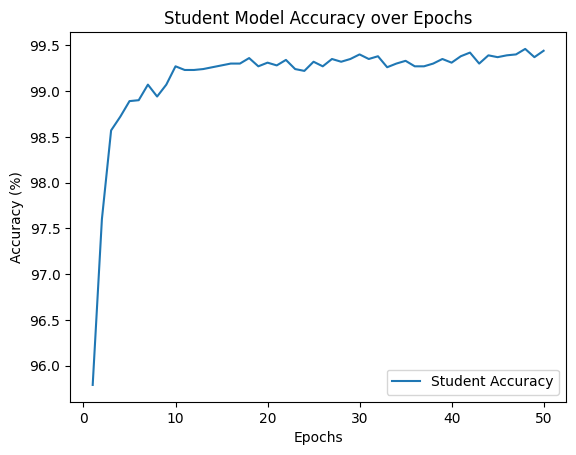

Student Model Accuracy: 99.44%


In [6]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

def train_student(student_model, teacher_model, train_loader, criterion, optimizer, epochs=50, temperature=2.0, alpha=0.5, test_loader=None):
    student_model.train()
    teacher_model.eval() 
    accuracies = []  

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()

           
            with torch.no_grad():
                teacher_outputs = teacher_model(images)

         
            student_outputs = student_model(images)

            loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature=temperature, alpha=alpha)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=5.0)

            optimizer.step()

        if test_loader is not None:
            student_model.eval()
            accuracy = evaluate_accuracy(student_model, test_loader)
            accuracies.append(accuracy)
            student_model.train()

    # illustration
    plt.plot(range(1, epochs+1), accuracies, label='Student Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Student Model Accuracy over Epochs')
    plt.legend()
    plt.show()

# initialize
student_model = StudentCNN().cuda()
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0001)

train_student(student_model, teacher_model, train_loader, distillation_loss, optimizer_student, epochs=50, temperature=2.0, alpha=0.5, test_loader=test_loader)

accuracy = evaluate_accuracy(student_model, test_loader)
print(f'Student Model Accuracy: {accuracy:.2f}%')





In [27]:

def train_and_attack_student(student_model, train_loader, test_loader, criterion, optimizer, epochs=40, epsilon=0.5, alpha=0.02, iterations=50):
    for param in student_model.parameters(): 
        param.requires_grad = True

    for epoch in range(epochs):
        student_model.train() 
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = student_model(images) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

       
        attack_success_rate = evaluate_attack_success(student_model, test_loader, epsilon, alpha, iterations)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Attack Success Rate: {attack_success_rate * 100:.2f}%')

train_and_attack_student(student_model, train_loader, test_loader, criterion, optimizer_student, epochs=40, epsilon=0.3, alpha=0.01, iterations=40)


Epoch 1/40, Loss: 0.0628, Attack Success Rate: 19.98%
Epoch 2/40, Loss: 0.0520, Attack Success Rate: 18.91%
Epoch 3/40, Loss: 0.0431, Attack Success Rate: 26.99%
Epoch 4/40, Loss: 0.0416, Attack Success Rate: 29.32%
Epoch 5/40, Loss: 0.0395, Attack Success Rate: 21.54%
Epoch 6/40, Loss: 0.0375, Attack Success Rate: 22.94%
Epoch 7/40, Loss: 0.0357, Attack Success Rate: 31.69%
Epoch 8/40, Loss: 0.0320, Attack Success Rate: 21.46%
Epoch 9/40, Loss: 0.0311, Attack Success Rate: 28.09%
Epoch 10/40, Loss: 0.0280, Attack Success Rate: 20.38%
Epoch 11/40, Loss: 0.0285, Attack Success Rate: 17.44%
Epoch 12/40, Loss: 0.0263, Attack Success Rate: 24.08%
Epoch 13/40, Loss: 0.0271, Attack Success Rate: 19.74%
Epoch 14/40, Loss: 0.0206, Attack Success Rate: 19.90%
Epoch 15/40, Loss: 0.0212, Attack Success Rate: 23.05%
Epoch 16/40, Loss: 0.0189, Attack Success Rate: 21.61%
Epoch 17/40, Loss: 0.0184, Attack Success Rate: 16.26%
Epoch 18/40, Loss: 0.0184, Attack Success Rate: 22.55%
Epoch 19/40, Loss: 

In [ ]:
import matplotlib.pyplot as plt


def train_and_attack_student(student_model, train_loader, test_loader, criterion, optimizer, epochs=40, epsilon=0.5, alpha=0.02, iterations=50):
    attack_success_rates = []  

    for param in student_model.parameters(): 
        param.requires_grad = True

    for epoch in range(epochs):
        student_model.train() 
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = student_model(images) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

     
        attack_success_rate = evaluate_attack_success(student_model, test_loader, epsilon, alpha, iterations)
        attack_success_rates.append(attack_success_rate)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Attack Success Rate: {attack_success_rate * 100:.2f}%')


    plt.plot(range(epochs), [rate * 100 for rate in attack_success_rates], marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate During Training (Student Model)')
    plt.xlabel('Epoch')
    plt.ylabel('Attack Success Rate (%)')
    plt.grid(True)
    plt.show()

train_and_attack_student(student_model, train_loader, test_loader, criterion, optimizer_student, epochs=40, epsilon=0.3, alpha=0.01, iterations=40)



Epoch 1/40, Loss: 0.0107, Attack Success Rate: 30.65%
Epoch 2/40, Loss: 0.0100, Attack Success Rate: 32.75%
Epoch 3/40, Loss: 0.0119, Attack Success Rate: 35.24%
Epoch 4/40, Loss: 0.0101, Attack Success Rate: 26.66%
Epoch 5/40, Loss: 0.0085, Attack Success Rate: 33.98%
Epoch 6/40, Loss: 0.0110, Attack Success Rate: 45.33%
Epoch 7/40, Loss: 0.0094, Attack Success Rate: 65.83%
Epoch 8/40, Loss: 0.0125, Attack Success Rate: 60.45%
Epoch 9/40, Loss: 0.0082, Attack Success Rate: 53.10%
Epoch 10/40, Loss: 0.0097, Attack Success Rate: 68.05%
Epoch 11/40, Loss: 0.0102, Attack Success Rate: 51.85%
Epoch 12/40, Loss: 0.0083, Attack Success Rate: 63.19%
Epoch 13/40, Loss: 0.0081, Attack Success Rate: 45.08%
Epoch 14/40, Loss: 0.0101, Attack Success Rate: 39.11%
Epoch 15/40, Loss: 0.0085, Attack Success Rate: 47.98%
Epoch 16/40, Loss: 0.0103, Attack Success Rate: 40.71%
Epoch 17/40, Loss: 0.0099, Attack Success Rate: 60.49%
Epoch 18/40, Loss: 0.0105, Attack Success Rate: 47.50%
Epoch 19/40, Loss: 